In [100]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os, sys
from scipy.stats import spearmanr
import sqlite3
import torch

sys.path.insert(0, '../src')
sys.path.insert(1, '..')

from main import get_model
from models.config import Config, IMAGE_TOKEN_IDS
import db_utils, visualizations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
sys.argv = ['notebooks/get_representations.ipynb',
            '--config', '../configs/models/qwen/Qwen2-VL-2B-Instruct-VisualFlow.yaml']

config = Config()

In [150]:
print(config.modules)

[regex.Regex('visual.blocks.31', flags=regex.V0), regex.Regex('visual.merger', flags=regex.V0), regex.Regex('model.norm', flags=regex.V0)]


In [151]:
model = get_model(config.architecture, config)
# print(model.model)


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


In [ ]:
print(model.model)


Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Seq

In [152]:
model.run(save_tokens=True)

Running forward hooks on data: 100%|██████████| 50/50 [00:06<00:00,  7.64it/s]


In [154]:
db_path = model.config.output_db
print(db_path)
connection = sqlite3.connect(db_path)
connection.row_factory = sqlite3.Row
cursor = connection.cursor()

../output/Qwen2-VL-2B-Instruct-VisualFlow.db


In [155]:
for r in cursor.execute("""
  SELECT DISTINCT layer
  FROM tensors
"""):
    print(dict(r))

{'layer': 'input_ids'}
{'layer': 'visual.blocks.31'}
{'layer': 'visual.merger'}
{'layer': 'model.norm'}


In [131]:
for r in cursor.execute("""
  SELECT id, image_id, timestamp, name, image_path, prompt, label, layer, pooling_method, tensor_dim, tensor_shape,
         length(tensor) AS tensor_bytes
  FROM tensors
  LIMIT 20
"""):
    print(dict(r))

{'id': 1, 'image_id': None, 'timestamp': '2025-10-13 18:43:47', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe the color in this image in one word.', 'label': None, 'layer': 'input_ids', 'pooling_method': None, 'tensor_dim': 1, 'tensor_shape': 'torch.Size([1, 175])', 'tensor_bytes': 2524}
{'id': 2, 'image_id': None, 'timestamp': '2025-10-13 18:43:47', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe the color in this image in one word.', 'label': None, 'layer': 'visual.blocks.31.mlp.fc2', 'pooling_method': None, 'tensor_dim': 1280, 'tensor_shape': 'torch.Size([576, 1280])', 'tensor_bytes': 1475740}
{'id': 3, 'image_id': None, 'timestamp': '2025-10-13 18:43:47', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Descri

In [ ]:
# Testing functions code, can delete later
input_ids = db_utils.get_embeddings_by_layer(
    db_path=db_path,
    layer_name="input_ids",
    device="cuda"
)

post_llm_embeddings = db_utils.get_embeddings_by_layer(
    db_path=db_path,
    layer_name="model.norm",
    device="cuda"
)

try:
    input_ids = np.squeeze(np.array(tuple(map(list, zip(*input_ids)))[1])) # B x T
    post_llm_embeddings = np.squeeze(np.array(tuple(map(list, zip(*post_llm_embeddings)))[1])) # B x T x D
    same_shapes = True
except Exception as e:
    print("Could not squeeze input IDs/LLM embeddings into 2D array: {}".format(e))
    input_ids = tuple(map(list, zip(*input_ids)))[1]
    post_llm_embeddings = tuple(map(list, zip(*post_llm_embeddings)))[1]
    same_shapes = False

visual_embs, n_visual_embs = db_utils.extract_visual_embeddings(
    input_ids=input_ids,
    llm_embeddings=post_llm_embeddings,
    image_token_id=IMAGE_TOKEN_IDS['qwen'],
    same_shapes=same_shapes)

mean_embs = db_utils.compute_mean_embeddings(
    embeddings=visual_embs,
    n_embeddings=n_visual_embs)

cosine_sim = db_utils.cosine_similarity_numpy(mean_embs, mean_embs)
# Sanity check that cosine sim with self is symmetric across diagonal
print(np.array_equal(cosine_sim, cosine_sim.T))


True


### For each image, calculate similarity of embeddings between pairs of layers

In [156]:
module_names = []
module_embeddings = []
# Get input_ids
input_ids = db_utils.get_embeddings_by_layer(
    db_path=db_path,
    layer_name="input_ids",
    device="cuda")
input_ids, input_ids_same_shapes = db_utils.unwrap_embeddings(input_ids)

for module in config.modules:
    module_name = module.pattern
    module_embedding = db_utils.get_embeddings_by_layer(
        db_path=db_path,
        layer_name=module.pattern
    )
    module_embedding, module_embedding_same_shapes = db_utils.unwrap_embeddings(module_embedding)

    # Compute mean embedding of visual tokens only (if applicable)
    if module_name.startswith("model."):
        module_visual_embedding, n_visual_tokens = db_utils.extract_visual_embeddings(
            input_ids=input_ids,
            llm_embeddings=module_embedding,
            image_token_id=IMAGE_TOKEN_IDS[config.architecture],
            same_shapes=module_embedding_same_shapes
        )
        # Calculate mean embedding
        visual_mean_embeddings = db_utils.compute_mean_embeddings(
            embeddings=module_visual_embedding,
            n_embeddings=n_visual_tokens)
        module_names.append("{}-visual".format(module_name))
        module_embeddings.append(visual_mean_embeddings)

    # Calculate mean embedding
    mean_embeddings = db_utils.compute_mean_embeddings(
        embeddings=module_embedding)

    module_names.append(module_name)
    module_embeddings.append(mean_embeddings)

print("Layers:")
for layer in module_names:
    print("\t{}".format(layer))
n_modules = len(module_names)

comparison_names = []
cosine_sims = []
for i in range(n_modules - 1):
    for j in range(i + 1, n_modules):
        # Check embeddings are same dimensions
        embedding_i = module_embeddings[i]
        embedding_j = module_embeddings[j]
        if not embedding_i.shape == embedding_j.shape:
            continue

        name_i = module_names[i]
        name_j = module_names[j]

        # Calculate cosine sim
        cosine_sim = db_utils.cosine_similarity_numpy(embedding_i, embedding_j)
        # Only want diagonal because that is comparing same image to same image
        cosine_sim = np.diag(cosine_sim)

        comparison_names.append("{}\n\/\n{}".format(name_i, name_j))
        cosine_sims.append(cosine_sim)

Layers:
	visual.blocks.31
	visual.merger
	model.norm-visual
	model.norm


1 rows; 4 columns


/n/fs/ac-aiexhibit/vlm-lens/notebooks/../src/visualizations.py:828: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


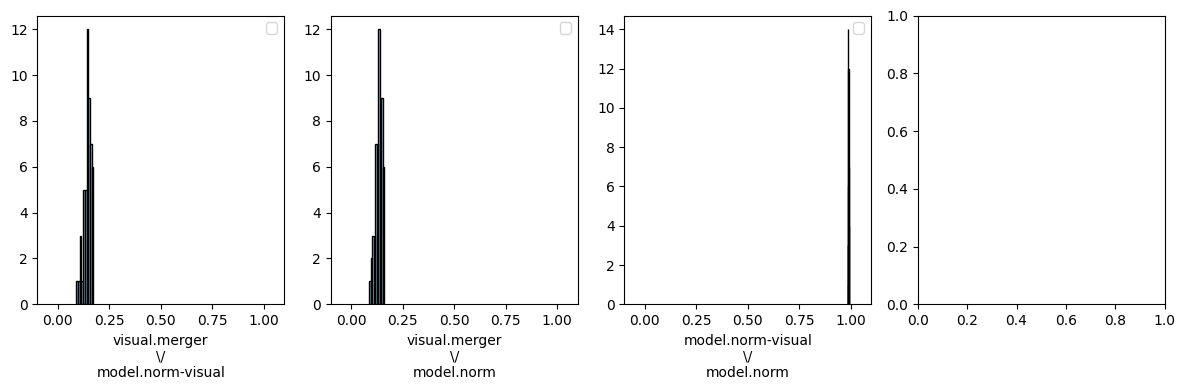

In [157]:
# Graph histograms of similarity scores for each pair of layers
n_graphs = len(comparison_names)
n_cols = 4
n_rows = n_graphs // n_cols + 1
print("{} rows; {} columns".format(n_rows, n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 4 * n_rows))

graph_idx = 0
# for idx in range(n_graphs):
for row_idx in range(n_rows):
    if graph_idx >= n_graphs:
        break
    for col_idx in range(n_cols):
        if graph_idx >= n_graphs:
            break
        if n_rows > 1:
            ax = axes[row_idx][col_idx]
        else:
            ax = axes[col_idx]
        comparison_name = comparison_names[graph_idx]
        cosine_sim = cosine_sims[graph_idx]

        fig, ax, _ = visualizations.histogram(
            data=cosine_sim,
            fig=fig,
            ax=ax,
            xlim=[-0.1, 1.1],
            xlabel=comparison_name,
            show=False
        )
        if n_rows > 1:
            axes[row_idx][col_idx] = ax
        else:
            axes[col_idx] = ax
        graph_idx += 1
plt.tight_layout()
plt.show()

### For each pair of images, calculate similarity at relevant layers

In [158]:
for name, embs in zip(module_names, module_embeddings):
    print(name, embs.shape)

visual.blocks.31 (50, 1280)
visual.merger (50, 1536)
model.norm-visual (50, 1536)
model.norm (50, 1536)


In [ ]:
# For each layer
module_similarities = []
for name, embs in zip(module_names, module_embeddings):

    # Compute similarity with same matrix
    module_sim = db_utils.cosine_similarity_numpy(embs, embs)
    # Assert similarity is symmetric
    assert np.array_equal(module_sim, module_sim.T)

    if name == "visual.blocks.31":
        print(embs[:5, :5])
        print(module_sim[:5, :5])
        print(np.mean(module_sim))
    # Get Upper Triangular Matrix values (excluding diagonal) and flatten
    n_samples = module_sim.shape[0]
    ut_idxs = np.triu_indices(n_samples, k=1)
    sim_values = module_sim[ut_idxs]
    assert len(sim_values) == n_samples * (n_samples - 1) / 2
    # Store values in list
    module_similarities.append(sim_values)



[[ 1.34326511  1.6141332  -0.57834456  0.17725923 -0.87570275]
 [ 1.61898465  1.38874986  0.39238993  1.07150057  0.01340061]
 [ 2.00302294 -0.26148309  0.15272183 -0.5243276  -0.39309523]
 [ 1.73375554  0.03116523  1.31141154  0.37809838 -0.26770104]
 [ 0.61153412  1.99178738 -0.02956136 -0.75128004 -0.4026786 ]]
[[1.         0.99993581 0.99995513 0.99995012 0.99995451]
 [0.99993581 1.         0.99996414 0.99996205 0.99994693]
 [0.99995513 0.99996414 1.         0.99997749 0.99995814]
 [0.99995012 0.99996205 0.99997749 1.         0.9999578 ]
 [0.99995451 0.99994693 0.99995814 0.9999578  1.        ]]
0.9999620614378375


6


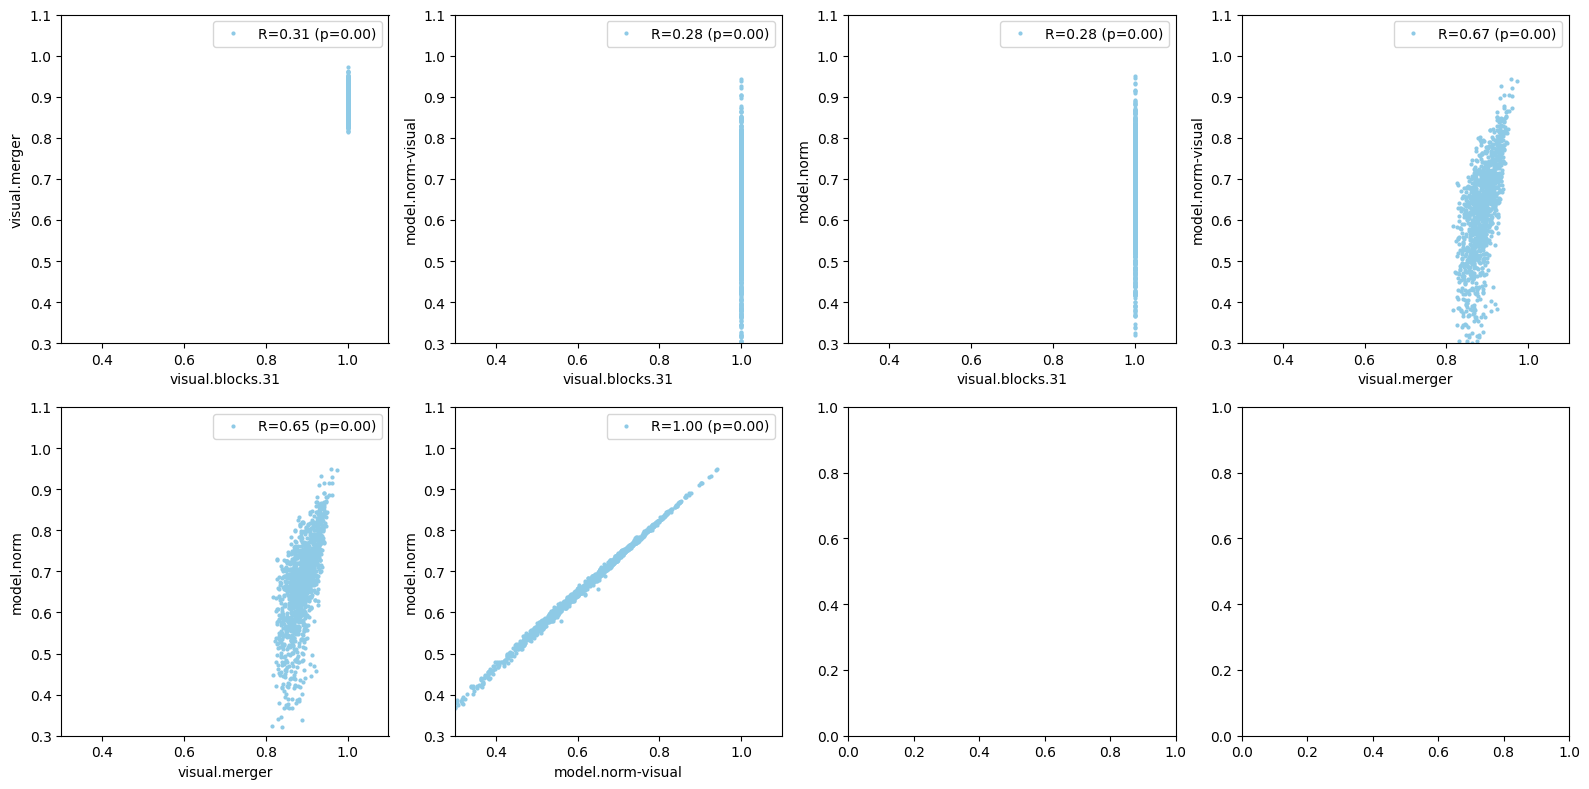

In [ ]:
n_layers = len(module_names)
n_graphs = int(n_layers * (n_layers - 1) / 2)

print(n_graphs)
n_cols = 4
n_rows = n_graphs // n_cols
if n_graphs % n_cols != 0:
    n_rows += 1
# For each pair of layers
row_idx = 0
col_idx = 0

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4 * n_cols, 4 * n_rows))
for layer_i in range(n_layers - 1):
    for layer_j in range(layer_i + 1, n_layers):
        if n_rows > 1:
            ax = axes[row_idx, col_idx]
        else:
            ax = axes[col_idx]
        name_i = module_names[layer_i]
        name_j = module_names[layer_j]

        sim_i = module_similarities[layer_i]
        sim_j = module_similarities[layer_j]

        # Calculate correlation
        corr, pval = spearmanr(sim_i, sim_j)

        fig, ax = visualizations.plot(
            fig=fig,
            ax=ax,
            xs=[sim_i],
            ys=[sim_j],
            line=False,
            marker_size=2,
            xlabel=name_i,
            ylabel=name_j,
            xlimits=[0.3, 1.1],
            ylimits=[0.3, 1.1],
            labels=['R={:.2f} (p={:.2f})'.format(corr, pval)]
        )
        if n_rows > 1:
            axes[row_idx, col_idx] = ax
        else:
            axes[col_idx] = ax

        # Update row and column idxs
        col_idx += 1
        if col_idx == n_cols:
            col_idx = 0
            row_idx += 1

plt.show()
# Get each similarity data array and plot

# Calculate correlation metric